In [1]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import thinkstats2
import thinkplot
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
sns.set()

from matplotlib.ticker import StrMethodFormatter
from datetime import datetime

# data
ks_data_raw = pd.read_csv("ks-projects-201801.csv")

# set seed
np.random.seed(530)

# Set pandas options
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None

In [2]:
ks_data_raw.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00


## Variables

name = Name of kickstarter title
category = Specific category of kickstarter
main_category = Category buckets of `category`
deadline = Date of deadline
launched = Date kickstarter event went live
state = Condition of the project
backers = Number of individuals backing the project
usd_goal_real = Goal amount converted to USD
usd_pledged_real = Amount pledged converted to USD

In [3]:
print(ks_data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


## Histograms & Data Cleaning

In [4]:
# Checking for null

print(ks_data_raw.isna().sum())

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


In [5]:
# Will create a new dataframe with cleaned up data types and columns

ks_data = pd.DataFrame()

# Add ID & name fields

ks_data['ID'] = ks_data_raw['ID']
ks_data['name'] = ks_data_raw['name']

# Convert a few to category type

ks_data['main_category'] = ks_data_raw['main_category'].astype('category')
ks_data['category'] = ks_data_raw['category'].astype('category')
ks_data['state'] = ks_data_raw['state'].astype('category')
ks_data['country'] = ks_data_raw['country'].astype('category')

# Need to convert date columns from string to datetime

ks_data['deadline'] = pd.to_datetime(ks_data_raw['deadline'])
ks_data['launched'] = pd.to_datetime(ks_data_raw['launched'])

# It seems the usd_*_real values are already cleaned up so we will use those instead of the raw fields

ks_data['goal'] = ks_data_raw['usd_goal_real']
ks_data['pledged'] = ks_data_raw['usd_pledged_real']

# Add Backers 

ks_data['backers'] = ks_data_raw['backers']

# Add column for number of days between launched and deadline

ks_data['days_to_complete'] = ((ks_data['deadline'] - ks_data['launched']).dt.days)

In [6]:
print(ks_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 12 columns):
ID                  378661 non-null int64
name                378657 non-null object
main_category       378661 non-null category
category            378661 non-null category
state               378661 non-null category
country             378661 non-null category
deadline            378661 non-null datetime64[ns]
launched            378661 non-null datetime64[ns]
goal                378661 non-null float64
pledged             378661 non-null float64
backers             378661 non-null int64
days_to_complete    378661 non-null int64
dtypes: category(4), datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 24.9+ MB
None


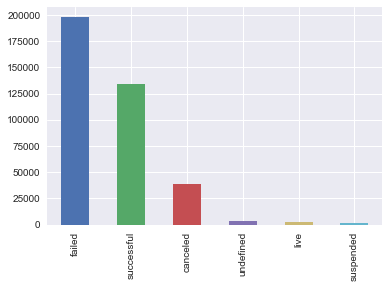

In [7]:
ks_data['state'].value_counts().plot(kind="bar")

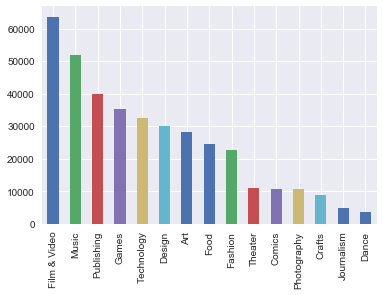

In [8]:
ks_data['main_category'].value_counts().plot(kind="bar")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000221CBD904E0>]],
      dtype=object)

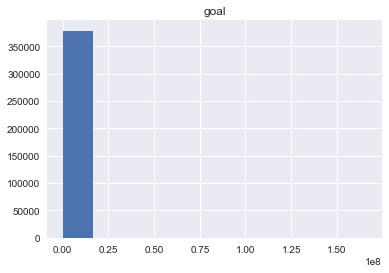

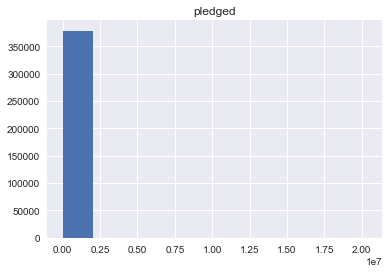

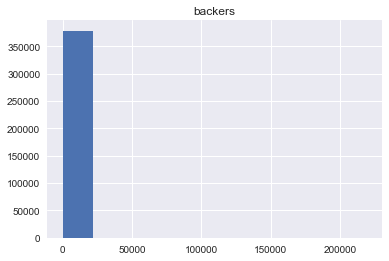

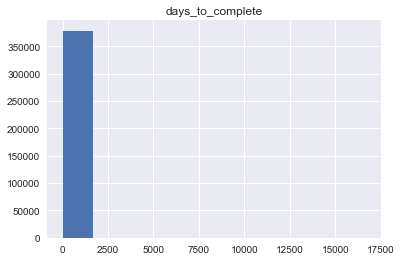

In [9]:
ks_data.hist(column='goal')
ks_data.hist(column='pledged')
ks_data.hist(column='backers')
ks_data.hist(column='days_to_complete')

As we can see from the histograms there are a lot of outliers.  One of the more surprising ones is days_to_complete, as the max value allowed for a kickstarter campaign is 60 days, so anything over that probably indicates bad data.

In [11]:
#ks_data_clean = ks_data[ks_data.launched >= '2000-01-01']
ks_data_clean = ks_data[ks_data.days_to_complete <= 60]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000221CBDBEA58>]],
      dtype=object)

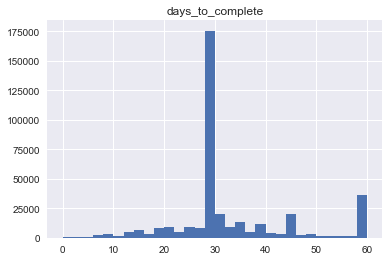

In [12]:
ks_data_clean.hist(column='days_to_complete', bins=30)

In [13]:
df_goal_outlier = ks_data_clean[np.abs(ks_data_clean.goal - ks_data_clean.goal.mean()) > 3 * ks_data_clean.goal.std()]
print(df_goal_outlier['main_category'].value_counts())
print(df_goal_outlier['state'].value_counts())

Film & Video    136
Technology       73
Games            30
Art              23
Publishing       19
Design           19
Food             17
Music            15
Theater          10
Journalism        9
Fashion           8
Photography       3
Comics            3
Crafts            1
Dance             0
Name: main_category, dtype: int64
failed        291
canceled       67
suspended       6
live            2
undefined       0
successful      0
Name: state, dtype: int64


It's reasonable that a lot of the large outliers of goals are either in the Film & Video category or Technology category as those are two categories that generally require more money to raise.  However, it's interesting that every single outlier of goal has been unsuccessful, which isn't that surprising but it leads me to wanting to plot the relationship between goal and chance of success.

## Descriptive Characteristics

In [14]:
ks_data_clean.describe()

,ID,goal,pledged,backers,days_to_complete
count,373945.00,373945.00,373945.00,373945.00,373945.00
mean,1074622592.81,45612.53,9135.58,106.49,32.60
std,619119513.50,1158052.25,91536.26,912.76,11.63
min,5971.00,0.01,0.00,0.00,0.00
25%,538051597.00,2000.00,30.54,2.00,29.00
50%,1075053871.00,5500.00,625.00,12.00,29.00
75%,1609998762.00,15726.48,4065.00,56.00,35.00
max,2147476221.00,166361390.71,20338986.27,219382.00,60.00


It doesn't seem possible that a kickstarter could have 0 backers and be successful so we will also get rid of those records.

In [15]:
ks_data_clean = ks_data_clean[ks_data_clean.backers > 0]

## PMF

In [16]:
success = ks_data_clean[ks_data_clean.state == 'successful']
failed = ks_data_clean[ks_data_clean.state == 'failed']
success_pmf = thinkstats2.Pmf(success.days_to_complete, label='success')
failed_pmf = thinkstats2.Pmf(failed.days_to_complete, label='failed')

30.583195983850725
33.7365169147669


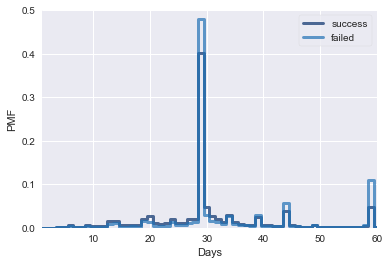

In [17]:
axis = [1, 60, 0, .5]
thinkplot.Pmfs([success_pmf, failed_pmf])
thinkplot.Config(xlabel='Days', ylabel='PMF', axis=axis)

print(success.days_to_complete.mean())
print(failed.days_to_complete.mean())

## CDF

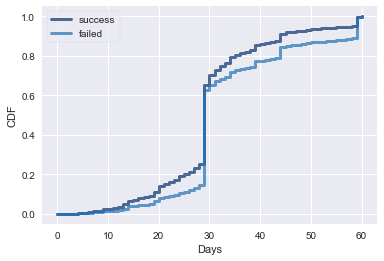

In [18]:
success_cdf = thinkstats2.Cdf(success.days_to_complete, label='success')
failed_cdf = thinkstats2.Cdf(failed.days_to_complete, label='failed')
thinkplot.Cdfs([success_cdf, failed_cdf])
thinkplot.Config(xlabel='Days', ylabel='CDF', loc='upper left')

We can see that the percentage of success and failures is roughly equal at around 30 Days.  However, less than 30 days we see higher percentage of successes than failures.

## Analytical Distribution

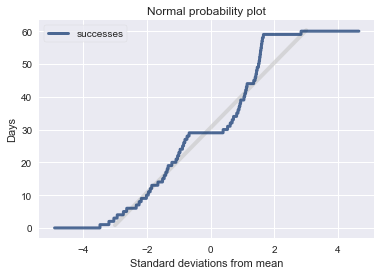

In [19]:
mean, var = thinkstats2.TrimmedMeanVar(success.days_to_complete, p=0.01)
std = np.sqrt(var)

xs = [-3, 3]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

xs, ys = thinkstats2.NormalProbability(success.days_to_complete)
thinkplot.Plot(xs, ys, label='successes')

thinkplot.Config(title='Normal probability plot',
                 xlabel='Standard deviations from mean',
                 ylabel='Days')

If certain number of days were better than others we would expect the probability of those days to deviate from norm.  It looks like between 22-29 days, as well as 45-59 have higher deviations from the norm and are therefore better ranges to set a kickstarter duration to.

## Scatterplots

Text(0,0.5,'Success Rate (%)')

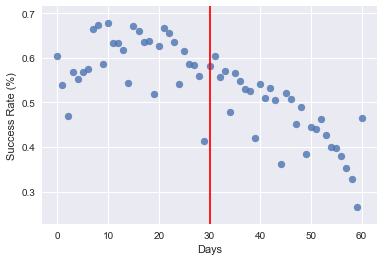

In [20]:
include_list = ['successful', 'failed']

ks_days = ks_data_clean[ks_data_clean['state'].isin(include_list)]
ks_days = ks_days[ks_days.days_to_complete <= 60]
ks_days_split = ks_days.groupby(['days_to_complete', 'state']).size().reset_index(name='count')
ks_days_total = ks_days.groupby(['days_to_complete']).size().reset_index(name='total')
ks_days = pd.merge(ks_days_split, ks_days_total, on='days_to_complete')
ks_days['pct'] = ks_days['count'] / ks_days['total']

ks_days_success = ks_days[ks_days['state'] == 'successful']
#ks_days_success.head(10)

plt.scatter(ks_days_success.days_to_complete, ks_days_success.pct, alpha=0.8)
plt.axvline(x=30, color='red')
plt.xlabel('Days')
plt.ylabel('Success Rate (%)')

As we can see from the graph above, Days before 30 have a much higher chance of success than after 30 days.  We can verify this: 

In [21]:
print("Chance of success for <30 Days:", ks_days_success[ks_days_success['days_to_complete'] < 30].pct.mean())
print("Chance of success for >30 Days:", ks_days_success[ks_days_success['days_to_complete'] > 30].pct.mean())

Chance of success for <30 Days: 0.5973960551778876
Chance of success for >30 Days: 0.46577790231850785


Here are some other scatterplots, but first, because the goal amount, backers and pledged amount can be rather large, I'm going to scale the data to a smaller range.

In [22]:
scaled_goal = (success.goal - success.goal.min()) / (success.goal.max() - success.goal.min())
scaled_backers = (success.backers - success.backers.min()) / (success.backers.max() - success.backers.min())
scaled_pledged = (success.pledged - success.pledged.min()) / (success.pledged.max() - success.pledged.min())
avg_per_backer = success.pledged / success.backers

No handles with labels found to put in legend.


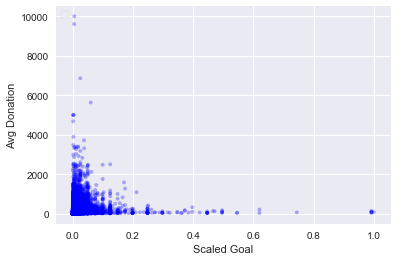

In [23]:
thinkplot.Scatter(scaled_goal, avg_per_backer, alpha=.3, s=15)
thinkplot.Config(xlabel='Scaled Goal', ylabel='Avg Donation')

In [24]:
np.corrcoef(scaled_goal, avg_per_backer)

array([[1.       , 0.1806874],
       [0.1806874, 1.       ]])

Here we are plotting the goal versus the Avg. Pledge Amount per Backer.  You would think the higher the goal would require getting people to spend more but rather, those more ambitious goal amounts just found more people to fund it rather than getting people to pay more.  The correlation between goal and avg per backer is a weak relationship at .180.

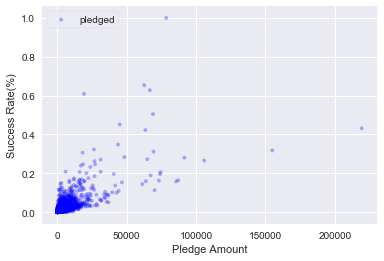

In [25]:
thinkplot.Scatter(success.backers, scaled_pledged, alpha=.3, s=15)
thinkplot.Config(xlabel='Pledge Amount', ylabel='Success Rate(%)')

In [26]:
np.corrcoef(success.backers, scaled_pledged)

array([[1.        , 0.74994455],
       [0.74994455, 1.        ]])

While backers versus pledged amount might not be the most interesting relationship, what is interesting is seeing the outliers.  The project that had the most backers raised less than 50% of the most funded project.  The correlation between backers and pledged amount is a strong relationship at .749.

## Hypothesis Testing

In [27]:
def RunTest(a, b, n):
    stat, p = stats.ttest_ind(a, b)
    print('%d\t%0.2f' % (n, p))

In [28]:
n = 1000

for _ in range(7):
    a = thinkstats2.SampleRows(success['days_to_complete'], n)
    b = thinkstats2.SampleRows(failed['days_to_complete'], n)
    RunTest(a, b, n)
    n //= 2

1000	0.00
500	0.00
250	0.00
125	0.00
62	0.05
31	0.59
15	0.20


### Regression Analysis

In [29]:
success['binarystate'] = 1
failed['binarystate'] = 0
ks_data_binarystate = pd.concat([success, failed])
ks_data_binarystate['state'] = ks_data_binarystate['state'].astype('category')
ks_data_binarystate.state = ks_data_binarystate.state.cat.remove_unused_categories()

formula = 'binarystate ~ days_to_complete'
model = smf.ols(formula, data=ks_data_binarystate)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            binarystate   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5635.
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:43:03   Log-Likelihood:            -2.0609e+05
No. Observations:              289259   AIC:                         4.122e+05
Df Residuals:                  289257   BIC:                         4.122e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6530      0.003  